# W4-11RE dataset

In [1]:
import json
import os
import pyscf
import numpy as np
from pyscf import gto, dft
from sigma.sigma import SIGMA
from sigma.usigma import USIGMA
from tqdm import tqdm
from sets import W4_11, W4_11RE

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
if not os.path.exists("json"):
    os.makedirs("json")

In [3]:
print("PySCF version:", pyscf.__version__)

PySCF version: 2.8.0


In [4]:
del W4_11.systems["c2"] # c2 converges to the solution with negative HOMO-LUMO gap with PBE

In [5]:
def atom_input(charges, xyz):
    """Construct input for mol.atom from charges and xyz."""
    atom_input_ = []
    for i in range(len(charges)):
        atom_input_.append([charges[i], tuple(xyz[i])])
    return atom_input_

In [6]:
def calc_one_system(atoms, coords, charge, spin, basis, xc):
    """Perform calculation for given system, basis and xc-functional."""
    mol = gto.Mole()
    mol.verbose = 0
    mol.atom = atom_input(atoms, coords)
    mol.basis = basis
    mol.charge = charge
    mol.spin = spin
    mol.build()

    if spin == 0:
        mf = dft.RKS(mol, xc=xc).density_fit().run()
        rpa = SIGMA(mf)
        rpa.kernel(nw=50, x0=2.5)
    else:
        mf = dft.UKS(mol, xc=xc).density_fit().run()
        rpa = USIGMA(mf)
        rpa.kernel(nw=50, x0=2.5)

    return float(mf.e_tot), float(rpa.e_tot_rpa), float(rpa.e_tot)

In [7]:
def eval_ds(reactions, etot):
    k = 0
    e_calc = np.zeros(len(reactions))
    e_ref = np.zeros(len(reactions))
    for i, _ in enumerate(reactions):
        ec = 0.0
        for j in range(len(reactions[i]["stoichiometry"])):
            ec += reactions[i]["stoichiometry"][j] * etot[reactions[i]["systems"][j]]
        e_calc[k] = ec * 627.50960803059
        e_ref[k] = reactions[i]["reference"]
        k += 1
    mae_all = np.mean(abs(e_calc - e_ref))
    return mae_all, e_calc, e_ref

In [8]:
def delete_systems_from_reactions(reactions, systems2remove):
    rs = []
    for r in reactions:
        nottoremove = True
        for s in r["systems"]:
            if s in systems2remove:
                nottoremove = False
        if nottoremove:
            rs.append(r)
    return rs

In [9]:
def plot_dev_histogram(e_sigma, e_rpa, e_dft, e_ref, mae_sigma, mae_rpa, mae_dft, xc, max_range, png_name=None):
    """Plot histogram for deviations from reference reaction energies."""
    fig, ax = plt.subplots(1, 1, figsize=(5.5,4))

    ydft = e_dft - e_ref
    ax.hist(ydft, 64, color='tab:green', range=(-max_range, max_range), alpha=0.5, label=f'{xc}')
    ax.hist(ydft, 64, histtype = 'step', color='k', lw = 1.0, range=(-max_range, max_range), alpha=1.0)

    yrpa = e_rpa - e_ref
    ax.hist(yrpa, 64, color='orangered',range=(-max_range, max_range), alpha=0.5, label=f'RPA@{xc}')
    ax.hist(yrpa, 64, histtype = 'step', color='k' ,range=(-max_range, max_range), lw = 1.0, alpha=1.0)

    ysigma = e_sigma - e_ref
    ax.hist(ysigma, 64, color='dodgerblue',range=(-max_range, max_range), alpha=0.5, label=f'$\\sigma$@{xc}')
    ax.hist(ysigma, 64, histtype = 'step', color='k' ,range=(-max_range, max_range), lw = 1.0, alpha=1.0)
    
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xlabel('Deviation', fontsize=12)

    ax.set_xlim(-max_range-0.1, max_range+0.1)

    ax.legend(loc=1,frameon=False, fontsize=12)

    plt.text(0.01, 0.94, f"MAE[{xc}]={mae_dft:.2f}", fontsize=12, weight="medium", transform=ax.transAxes)
    plt.text(0.01, 0.88, f"MAE[RPA@{xc}]={mae_rpa:.2f}", fontsize=12, weight="medium", transform=ax.transAxes)
    plt.text(0.01, 0.82, f"MAE[$\\sigma$@{xc}]={mae_sigma:.2f}", fontsize=12, weight="medium", transform=ax.transAxes)

    plt.tight_layout()

    if png_name is not None:
        plt.savefig(png_name, dpi=600)
    plt.show()

### PBE and RPA@PBE

In [10]:
# Note that in original publications quadruple orbital basis sets were employed
BASIS_T = {"H":  "aug-cc-pVTZ",
           "Be": "aug-cc-pVTZ",
           "B":  "aug-cc-pwCVTZ",
           "C":  "aug-cc-pwCVTZ",
           "N":  "aug-cc-pwCVTZ",
           "O":  "aug-cc-pwCVTZ",
           "F":  "aug-cc-pwCVTZ",
           "Al": "aug-cc-pwCVTZ",
           "Si": "aug-cc-pwCVTZ",
           "P":  "aug-cc-pwCVTZ",
           "S":  "aug-cc-pwCVTZ",
           "Cl": "aug-cc-pwCVTZ"}

In [11]:
reactions = delete_systems_from_reactions(W4_11RE.reactions, ["c2"])

#### aug-cc-pwCVTZ orbital basis set

In [12]:
if os.path.isfile("json/W4-11_PBE_T.json"):
    print('Reading results from W4-11_PBE_T.json')
    with open("json/W4-11_PBE_T.json", 'r') as file_obj:
        (etot_pbe, etot_rpa, etot_sigma) = json.load(file_obj)
else:
    etot_pbe = dict()
    etot_rpa = dict()
    etot_sigma = dict()
    pbar = tqdm(sorted(W4_11.systems))
    for system in pbar:
        e_pbe, e_rpa, e_sigma = calc_one_system(W4_11.systems[system]["atoms"],
                                                W4_11.systems[system]["coords"],
                                                W4_11.systems[system]["charge"],
                                                W4_11.systems[system]["spin"],
                                                BASIS_T,
                                                "pbe")
        etot_pbe[system] = e_pbe
        etot_rpa[system] = e_rpa
        etot_sigma[system] = e_sigma
    with open('json/W4-11_PBE_T.json', 'w', encoding='utf-8') as file_obj:
        json.dump((etot_pbe, etot_rpa, etot_sigma), file_obj, ensure_ascii=False, indent=4)

Reading results from W4-11_PBE_T.json


In [13]:
mae_pbe, re_pbe, re_ref = eval_ds(reactions, etot_pbe)
mae_rpa, re_rpa, re_ref = eval_ds(reactions, etot_rpa)
mae_sigma, re_sigma, re_ref = eval_ds(reactions, etot_sigma)

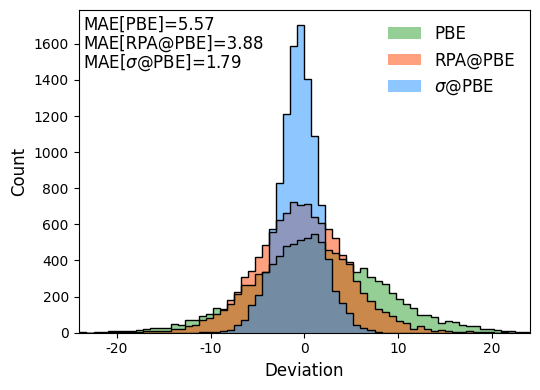

In [14]:
plot_dev_histogram(re_sigma, re_rpa, re_pbe, re_ref, mae_sigma, mae_rpa, mae_pbe, "PBE", 24)

#### aug-cc-pwCVQZ orbital basis set

In [15]:
# Note that in original publications quadruple orbital basis sets were employed
BASIS_Q = {"H":  "aug-cc-pVQZ",
           "Be": "aug-cc-pVQZ",
           "B":  "aug-cc-pwCVQZ",
           "C":  "aug-cc-pwCVQZ",
           "N":  "aug-cc-pwCVQZ",
           "O":  "aug-cc-pwCVQZ",
           "F":  "aug-cc-pwCVQZ",
           "Al": "aug-cc-pwCVQZ",
           "Si": "aug-cc-pwCVQZ",
           "P":  "aug-cc-pwCVQZ",
           "S":  "aug-cc-pwCVQZ",
           "Cl": "aug-cc-pwCVQZ"}

In [16]:
if os.path.isfile("json/W4-11_PBE_Q.json"):
    print('Reading results from W4-11_PBE_Q.json')
    with open("json/W4-11_PBE_Q.json", 'r') as file_obj:
        (etot_pbe, etot_rpa, etot_sigma) = json.load(file_obj)
else:
    etot_pbe = dict()
    etot_rpa = dict()
    etot_sigma = dict()
    pbar = tqdm(sorted(W4_11.systems))
    for system in pbar:
        e_pbe, e_rpa, e_sigma = calc_one_system(W4_11.systems[system]["atoms"],
                                                W4_11.systems[system]["coords"],
                                                W4_11.systems[system]["charge"],
                                                W4_11.systems[system]["spin"],
                                                BASIS_Q,
                                                "pbe")
        etot_pbe[system] = e_pbe
        etot_rpa[system] = e_rpa
        etot_sigma[system] = e_sigma
    with open('json/W4-11_PBE_Q.json', 'w', encoding='utf-8') as file_obj:
        json.dump((etot_pbe, etot_rpa, etot_sigma), file_obj, ensure_ascii=False, indent=4)

Reading results from W4-11_PBE_Q.json


In [17]:
mae_pbe, re_pbe, re_ref = eval_ds(reactions, etot_pbe)
mae_rpa, re_rpa, re_ref = eval_ds(reactions, etot_rpa)
mae_sigma, re_sigma, re_ref = eval_ds(reactions, etot_sigma)

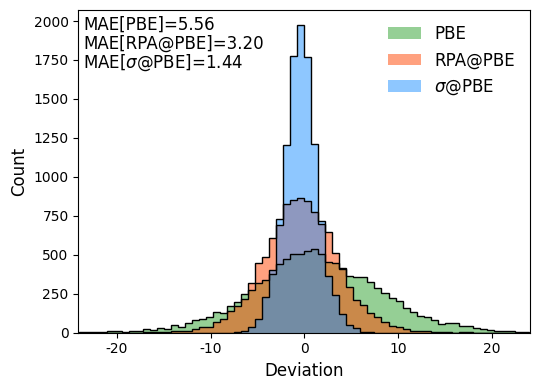

In [18]:
plot_dev_histogram(re_sigma, re_rpa, re_pbe, re_ref, mae_sigma, mae_rpa, mae_pbe, "PBE", 24, "PBE_W4_11RE.png")

### PBE0 and RPA@PBE0

#### aug-cc-pwCVTZ orbital basis set

In [19]:
if os.path.isfile("json/W4-11_PBE0_T.json"):
    print('Reading results from W4-11_PBE0_T.json')
    with open("json/W4-11_PBE0_T.json", 'r') as file_obj:
        (etot_pbe0, etot_rpa, etot_sigma) = json.load(file_obj)
else:
    etot_pbe0 = dict()
    etot_rpa = dict()
    etot_sigma = dict()
    pbar = tqdm(sorted(W4_11.systems))
    for system in pbar:
        e_pbe0, e_rpa, e_sigma = calc_one_system(W4_11.systems[system]["atoms"],
                                                 W4_11.systems[system]["coords"],
                                                 W4_11.systems[system]["charge"],
                                                 W4_11.systems[system]["spin"],
                                                 BASIS_T,
                                                 "pbe0")
        etot_pbe0[system] = e_pbe0
        etot_rpa[system] = e_rpa
        etot_sigma[system] = e_sigma
    with open('json/W4-11_PBE0_T.json', 'w', encoding='utf-8') as file_obj:
        json.dump((etot_pbe0, etot_rpa, etot_sigma), file_obj, ensure_ascii=False, indent=4)

Reading results from W4-11_PBE0_T.json


In [20]:
mae_pbe0, re_pbe0, re_ref = eval_ds(reactions, etot_pbe0)
mae_rpa, re_rpa, re_ref = eval_ds(reactions, etot_rpa)
mae_sigma, re_sigma, re_ref = eval_ds(reactions, etot_sigma)

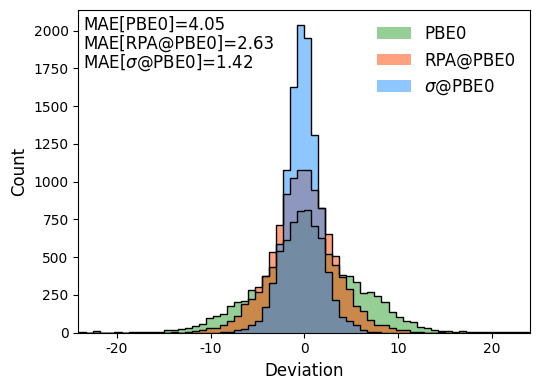

In [21]:
plot_dev_histogram(re_sigma, re_rpa, re_pbe0, re_ref, mae_sigma, mae_rpa, mae_pbe0, "PBE0", 24)

#### aug-cc-pwCVQZ orbital basis set

In [22]:
if os.path.isfile("json/W4-11_PBE0_Q.json"):
    print('Reading results from W4-11_PBE0_Q.json')
    with open("json/W4-11_PBE0_Q.json", 'r') as file_obj:
        (etot_pbe0, etot_rpa, etot_sigma) = json.load(file_obj)
else:
    etot_pbe0 = dict()
    etot_rpa = dict()
    etot_sigma = dict()
    pbar = tqdm(sorted(W4_11.systems))
    for system in pbar:
        e_pbe0, e_rpa, e_sigma = calc_one_system(W4_11.systems[system]["atoms"],
                                                 W4_11.systems[system]["coords"],
                                                 W4_11.systems[system]["charge"],
                                                 W4_11.systems[system]["spin"],
                                                 BASIS_Q,
                                                 "pbe0")
        etot_pbe0[system] = e_pbe0
        etot_rpa[system] = e_rpa
        etot_sigma[system] = e_sigma
    with open('json/W4-11_PBE0_Q.json', 'w', encoding='utf-8') as file_obj:
        json.dump((etot_pbe0, etot_rpa, etot_sigma), file_obj, ensure_ascii=False, indent=4)

Reading results from W4-11_PBE0_Q.json


In [23]:
mae_pbe0, re_pbe0, re_ref = eval_ds(reactions, etot_pbe0)
mae_rpa, re_rpa, re_ref = eval_ds(reactions, etot_rpa)
mae_sigma, re_sigma, re_ref = eval_ds(reactions, etot_sigma)

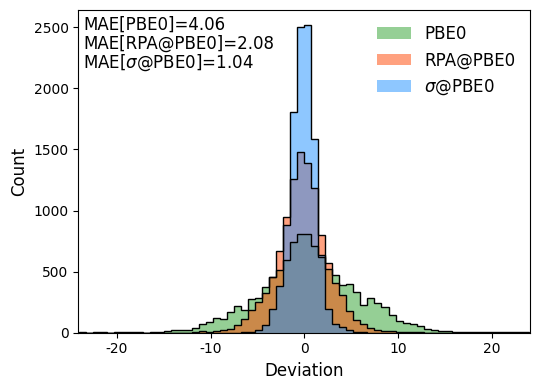

In [24]:
plot_dev_histogram(re_sigma, re_rpa, re_pbe0, re_ref, mae_sigma, mae_rpa, mae_pbe0, "PBE0", 24, "PBE0_W4_11RE.png")